In [1]:
defaultW <- getOption("warn")
options(warn = -1)
library(sp)
library(sf)
library(rgdal)
library(rgeos)
library(maptools)
library(stringr)
library(spdep)
library(spatstat)
library(splancs)
#gpclibPermit()
library(raster)
library(data.table)
require(spatialreg)
options(warn = defaultW)

Linking to GEOS 3.9.0, GDAL 3.2.1, PROJ 7.2.1

rgdal: version: 1.5-23, (SVN revision 1121)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.2.1, released 2020/12/29
Path to GDAL shared files: C:/Users/peppu/Documents/R/win-library/4.0/rgdal/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 7.2.1, January 1st, 2021, [PJ_VERSION: 721]
Path to PROJ shared files: C:/Users/peppu/Documents/R/win-library/4.0/rgdal/proj
PROJ CDN enabled: FALSE
Linking to sp version:1.4-5
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportToProj4_warnings"="none") before loading rgdal.
Overwritten PROJ_LIB was C:/Users/peppu/Documents/R/win-library/4.0/rgdal/proj

rgeos version: 0.5-5, (SVN revision 640)
 GEOS runtime version: 3.8.0-CAPI-1.13.1 
 Linking to sp version: 1.4-5 
 Polygon checking: TRUE 


Checking rgeos availability: TRUE

Loading required package: spData

To access larger datasets in t

# 0 - Problem Statement 
da scrivere

# 1 - Load shape file for regions and districts

In [2]:
ita_prov = readOGR("external_shp/ProvCM01012018_g/ProvCM01012018_g_WGS84.shp")
ita_reg = readOGR("external_shp/Reg01012018_g/Reg01012018_g_WGS84.shp")
head(as.data.frame(ita_prov))

OGR data source with driver: ESRI Shapefile 
Source: "C:\Users\peppu\Documents\MyPythonProject\geospatial_project\external_shp\ProvCM01012018_g\ProvCM01012018_g_WGS84.shp", layer: "ProvCM01012018_g_WGS84"
with 107 features
It has 12 fields
Integer64 fields read as strings:  COD_RIP COD_REG COD_PROV COD_CM COD_PCM 
OGR data source with driver: ESRI Shapefile 
Source: "C:\Users\peppu\Documents\MyPythonProject\geospatial_project\external_shp\Reg01012018_g\Reg01012018_g_WGS84.shp", layer: "Reg01012018_g_WGS84"
with 20 features
It has 6 fields
Integer64 fields read as strings:  COD_RIP COD_REG 


,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_PCM,DEN_PROV,DEN_CM,DEN_PCM,SIGLA,SHAPE_LENG,SHAPE_AREA,SHAPE_LEN
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
0,1,1,1,201,201,-,Torino,Torino,TO,539249.8,6828137329,539249.8
1,1,1,2,0,2,Vercelli,-,Vercelli,VC,418249.3,2082027827,418249.3
2,1,1,3,0,3,Novara,-,Novara,NO,250242.4,1341319564,250242.4
3,1,1,4,0,4,Cuneo,-,Cuneo,CN,490111.9,6898443198,490111.9
4,1,1,5,0,5,Asti,-,Asti,AT,315561.4,1508948105,315561.4
5,1,1,6,0,6,Alessandria,-,Alessandria,AL,474880.9,3560304556,474880.9


In [3]:
ita_prov$COD_REG = as.numeric(ita_prov$COD_REG) # convert region code into numeric

## 1.1 COVID cases calculation
Read COVID data for all the districts

In [4]:
dati_prov_covid = read.csv("C:/Users/peppu/Documents/MyPythonProject/COVID-19/dati-province/dpc-covid19-ita-province.csv")
dati_prov_covid_jan21 = dati_prov_covid[(dati_prov_covid$data %like% "2021-01") | (dati_prov_covid$data %like% "2020-12"), ]
dati_prov_covid_jan21$COD_PROV = dati_prov_covid_jan21$codice_provincia
dati_prov_covid_jan21$COD_REG = dati_prov_covid_jan21$codice_regione

Calculate for each district the new number of cases in DEC-2020 to JAN-2021.

In [5]:
unique_prov = unique(dati_prov_covid_jan21$COD_PROV)
prov_arr = c()
tot_casi_prov = c()
for(i in unique_prov) {
    tot_casi=0
    df = subset(dati_prov_covid_jan21, COD_PROV==i)
    tot_casi = max(df$totale_casi)-min(df$totale_casi)
    prov_arr = c(prov_arr,i)
    tot_casi_prov = c(tot_casi_prov,tot_casi)
}
sum_cases = data.frame(prov_arr, tot_casi_prov)
colnames(sum_cases) = c('COD_PROV','case_sum')
head(sum_cases)

,COD_PROV,case_sum
,<int>,<int>
1,66,2953
2,67,3511
3,68,3576
4,69,4298
5,879,116
6,979,52


Merge the spatial dataframe with the districts information

In [6]:
# ita_prov_new = merge(ita_prov,dati_prov_covid_jan21,by="COD_PROV")
ita_prov = merge(ita_prov,sum_cases,by="COD_PROV")

## 1.2 ISTAT region features
Get from COVID dataset the features for each region; since the dataset is in region and not in district I divide by the area of the region to get the density and then multiply by the area of the district.

In [7]:
# Calculate the area of each region
reg_area_df = data.frame(ita_reg$COD_REG,area(ita_reg))
colnames(reg_area_df) = c('COD_REG','area')
dati_stat = read.csv("C:/Users/peppu/Documents/MyPythonProject/COVID-19/dati-statistici-riferimento/popolazione-istat-regione-range.csv")
dati_stat$COD_REG = as.numeric(dati_stat$codice_regione)
head(dati_stat)

,codice_regione,codice_nuts_1,descrizione_nuts_1,codice_nuts_2,denominazione_regione,sigla_regione,latitudine_regione,longitudine_regione,range_eta,totale_genere_maschile,totale_genere_femminile,totale_generale,COD_REG
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<dbl>
1,13,ITF,Sud,ITF1,Abruzzo,ABR,42.35122,13.39844,0-15,87423,82474,169897,13
2,13,ITF,Sud,ITF1,Abruzzo,ABR,42.35122,13.39844,16-19,24402,22349,46751,13
3,13,ITF,Sud,ITF1,Abruzzo,ABR,42.35122,13.39844,20-29,67472,62611,130083,13
4,13,ITF,Sud,ITF1,Abruzzo,ABR,42.35122,13.39844,30-39,76472,74241,150713,13
5,13,ITF,Sud,ITF1,Abruzzo,ABR,42.35122,13.39844,40-49,94745,95315,190060,13
6,13,ITF,Sud,ITF1,Abruzzo,ABR,42.35122,13.39844,50-59,100048,104109,204157,13


Calculate the number of inhabitants based on age range and sex for each district.

In [8]:
# Initialize dataframe with age range and sex
unique_range_eta = unique(dati_stat$range_eta)
for(r_eta in unique_range_eta){    
    new_str = str_replace(r_eta,'-','_')
    new_str = str_replace(new_str,'\\+','plus')
    new_str = paste("var_", new_str, sep="")
    dati_stat[dati_stat==r_eta] = new_str
    }
unique_range_eta = unique(dati_stat$range_eta)
for(r_eta in unique_range_eta){
    ita_prov[[paste(r_eta, "_tot", sep="")]] = 0
    ita_prov[[paste(r_eta, "_tot_male", sep="")]] = 0
    ita_prov[[paste(r_eta, "_tot_female", sep="")]]= 0
}
# Iterate over each district to calculate the number of people in each age range and sex
unique_prov = unique(ita_prov$COD_PROV)
for(current_prov_cod in unique_prov) {
    current_prov = subset(ita_prov,COD_PROV==current_prov_cod) # Current district spatial DF
    area_prov = area(current_prov) # get area of current district
    
    current_region_cod = current_prov$COD_REG # Current region ID    
    area_reg = subset(reg_area_df,COD_REG==current_region_cod)$area # get area of current district
    
    if (area_prov/area_reg>1){
        message(current_prov$DEN_PROV)
        raise_error
    }
    
    # Iterate over each age range
    for(r_eta in unique_range_eta) {
        
        if (current_prov_cod==21){ # mange BOLZANO
            current_region_cod = 21
        }
        if (current_prov_cod==22){ # manage TRENTO
            current_region_cod = 22
        }
        current_reg_range = subset(dati_stat, (COD_REG==current_region_cod) & (range_eta==r_eta))
        tot_generale = as.integer(current_reg_range$totale_generale)
        tot_male = as.integer(current_reg_range$totale_genere_maschile)
        tot_female = as.integer(current_reg_range$totale_genere_femminile)
        
        tot_generale_prov = as.integer(tot_generale*area_prov/area_reg)
        tot_male_prov = as.integer(tot_male*area_prov/area_reg)
        tot_female_prov = as.integer(tot_female*area_prov/area_reg)
        
        ita_prov[[paste(r_eta, "_tot", sep="")]][ita_prov$COD_PROV==current_prov_cod] = tot_generale_prov
        ita_prov[[paste(r_eta, "_tot_male", sep="")]][ita_prov$COD_PROV==current_prov_cod] = tot_male_prov
        ita_prov[[paste(r_eta, "_tot_female", sep="")]][ita_prov$COD_PROV==current_prov_cod] = tot_female_prov
    
    }
}

Calculate the number of inhabintants and the relative increase of cases.

In [9]:
all_eta = c()
for(r_eta in unique_range_eta){
    all_eta=c(all_eta,paste(r_eta, "_tot", sep=""))
}
ita_prov$inhabitants = rowSums(as.data.frame(ita_prov[all_eta]))
ita_prov$case_sum_rel = ita_prov$case_sum/ita_prov$inhabitants
head(as.data.frame(ita_prov[c('DEN_PCM',all_eta,'inhabitants','case_sum','case_sum_rel')]))

,DEN_PCM,var_0_15_tot,var_16_19_tot,var_20_29_tot,var_30_39_tot,var_40_49_tot,var_50_59_tot,var_60_69_tot,var_70_79_tot,var_80_89_tot,var_90plus_tot,inhabitants,case_sum,case_sum_rel
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1,Torino,151532,41306,109220,123518,170138,185183,150102,128371,82471,17393,1159234,26628,0.022970341
20,Vercelli,46205,12595,33303,37663,51878,56465,45769,39143,25147,5303,353471,1914,0.005414871
31,Novara,29767,8114,21455,24264,33421,36377,29486,25217,16200,3416,227717,4551,0.019985333
42,Cuneo,153092,41731,110344,124790,171890,187090,151647,129693,83320,17572,1171169,7345,0.006271512
53,Asti,33487,9128,24136,27296,37598,40923,33171,28368,18225,3843,256175,3712,0.014490095
64,Alessandria,79011,21537,56949,64404,88712,96557,78265,66935,43002,9069,604441,5214,0.008626152


## 1.3 Write SHAPE file into local folder for GeoDa analysis

In [10]:
writeOGR(ita_prov, "output/province_sum_cases.shp", "", driver="ESRI Shapefile")

Warning message in writeOGR(ita_prov, "output/province_sum_cases.shp", "", driver = "ESRI Shapefile"):
"Field names abbreviated for ESRI Shapefile driver"
Warning message in writeOGR(ita_prov, "output/province_sum_cases.shp", "", driver = "ESRI Shapefile"):
"field names vr_0_15_tt_m, vr_0_15_tt_f, vr_16_19_tt_m, vr_16_19_tt_f, vr_20_29_tt_m, vr_20_29_tt_f, vr_30_39_tt_m, vr_30_39_tt_f, vr_40_49_tt_m, vr_40_49_tt_f, vr_50_59_tt_m, vr_50_59_tt_f, vr_60_69_tt_m, vr_60_69_tt_f, vr_70_79_tt_m, vr_70_79_tt_f, vr_80_89_tt_m, vr_80_89_tt_f, vr_90pls_tt_m, vr_90pls_tt_f changed by driver to: vr_0_15_tt, vr_0_15__1, vr_16_19_t, vr_16_19_1, vr_20_29_t, vr_20_29_1, vr_30_39_t, vr_30_39_1, vr_40_49_t, vr_40_49_1, vr_50_59_t, vr_50_59_1, vr_60_69_t, vr_60_69_1, vr_70_79_t, vr_70_79_1, vr_80_89_t, vr_80_89_1, vr_90pls_t, vr_90pls_1"


# 2 - Spatial Analysis

Plot Italy and its districts with centroids (this step is just to check the validity of the shapefile)

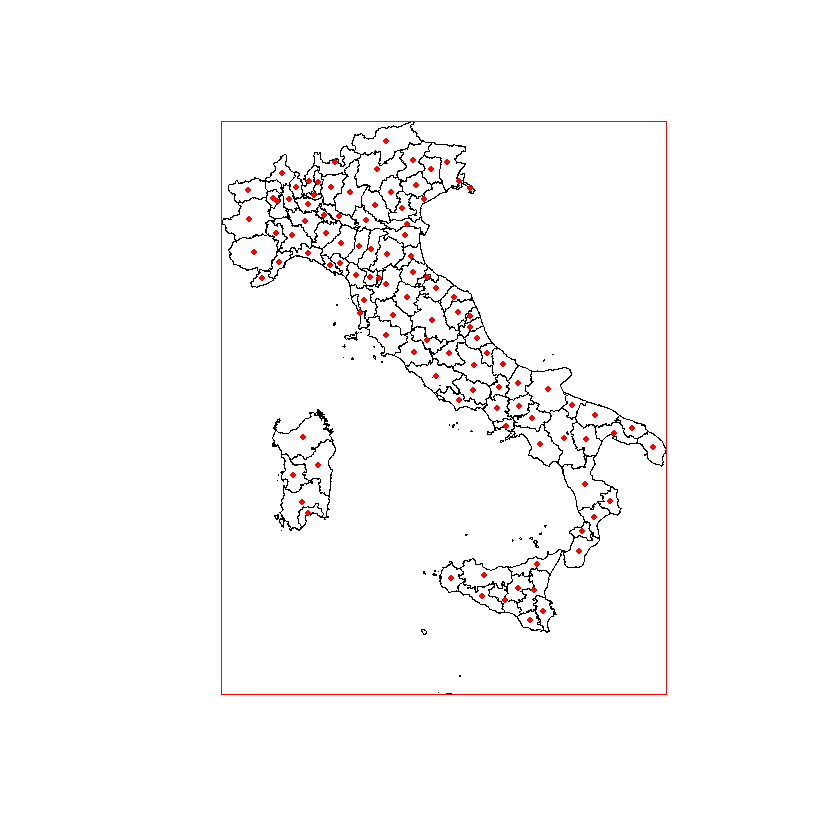

In [11]:
options(jupyter.plot_scale=1.1)
prov_center <- coordinates(ita_prov)
ita_bbox <- bbox(ita_prov)
plot(ita_prov)
plot(extent(ita_bbox),add=T,col='red')  #bounding box
points(prov_center, col='red',pch=20)  #centroidi

## 2.1 Global Moran Index Calculation (check GeoDa)
Calculate the Global Moran Index on the number of new cases (case_sum column) and relative number of new cases (case_sum_rel)

Here I used the queen first order distance; it is exactly the same of the rook in this case (checked with GeoDa). <br>
The Moran Index has been calculated also using a Monte Carlo procedure in order to test it's significance. <br>
Based on both the Moran randomisation test and on Monte Carlo simulation it is possible to state that there is a very small spatial autocorrelation (it is possible to refuse the null hypothesis of no spatial autocorrelation). <br>


	Moran I test under randomisation

data:  ita_prov$case_sum  
weights: adj_matrix_norm    

Moran I statistic standard deviate = 2.1475, p-value = 0.01588
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.130293362      -0.009433962       0.004233329 



	Monte-Carlo simulation of Moran I

data:  ita_prov$case_sum 
weights: adj_matrix_norm  
number of simulations + 1: 201 

statistic = 0.13029, observed rank = 196, p-value = 0.02488
alternative hypothesis: greater



	Geary C test under randomisation

data:  ita_prov$case_sum 
weights: adj_matrix_norm 

Geary C statistic standard deviate = 1.3264, p-value = 0.09236
alternative hypothesis: Expectation greater than statistic
sample estimates:
Geary C statistic       Expectation          Variance 
       0.89192842        1.00000000        0.00663891 


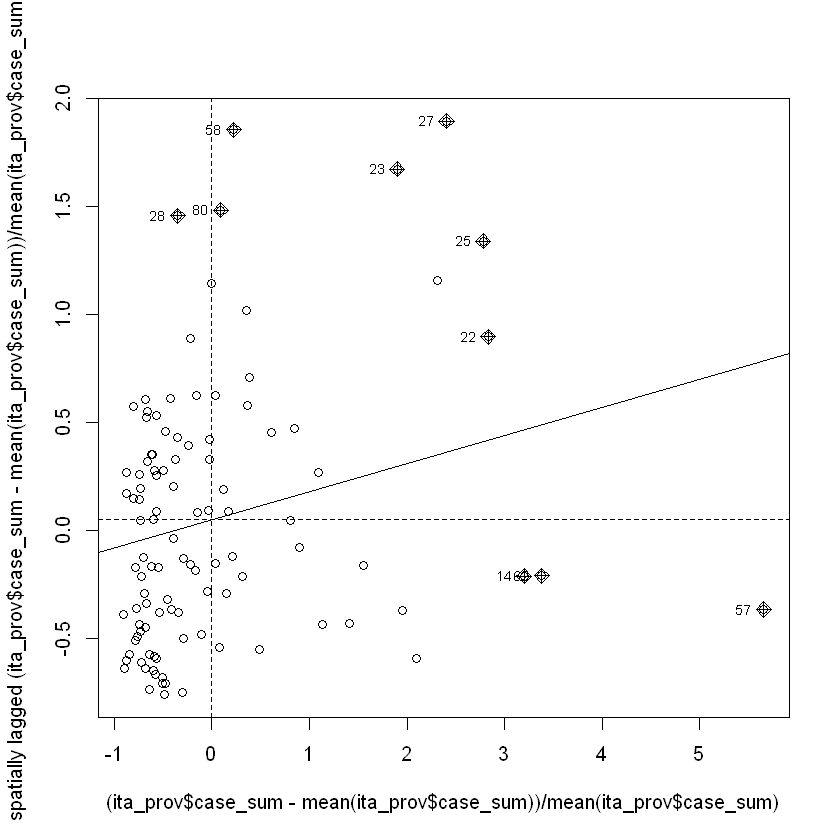

In [12]:
options(jupyter.plot_scale=1.3)
adj_matrix = poly2nb(ita_prov, queen=T)
adj_matrix_norm <- nb2listw(adj_matrix, style = "W")
moran.test(ita_prov$case_sum, adj_matrix_norm)
moran.mc(ita_prov$case_sum, adj_matrix_norm, nsim=200)
geary.test(ita_prov$case_sum, adj_matrix_norm)
moran.plot((ita_prov$case_sum-mean(ita_prov$case_sum))/mean(ita_prov$case_sum), adj_matrix_norm)

Exactly the same plot has been done on the relative increase in number of cases. <br>
Here the Moran Index is still significant but it seems that there is an higher spatial correlation (0.25 vs 0.13).


	Moran I test under randomisation

data:  ita_prov$case_sum_rel  
weights: adj_matrix_norm    

Moran I statistic standard deviate = 4.6702, p-value = 1.505e-06
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.257756258      -0.009433962       0.003273207 



	Monte-Carlo simulation of Moran I

data:  ita_prov$case_sum_rel 
weights: adj_matrix_norm  
number of simulations + 1: 201 

statistic = 0.25776, observed rank = 201, p-value = 0.004975
alternative hypothesis: greater



	Geary C test under randomisation

data:  ita_prov$case_sum_rel 
weights: adj_matrix_norm 

Geary C statistic standard deviate = 3.7124, p-value = 0.0001026
alternative hypothesis: Expectation greater than statistic
sample estimates:
Geary C statistic       Expectation          Variance 
       0.59776291        1.00000000        0.01173946 


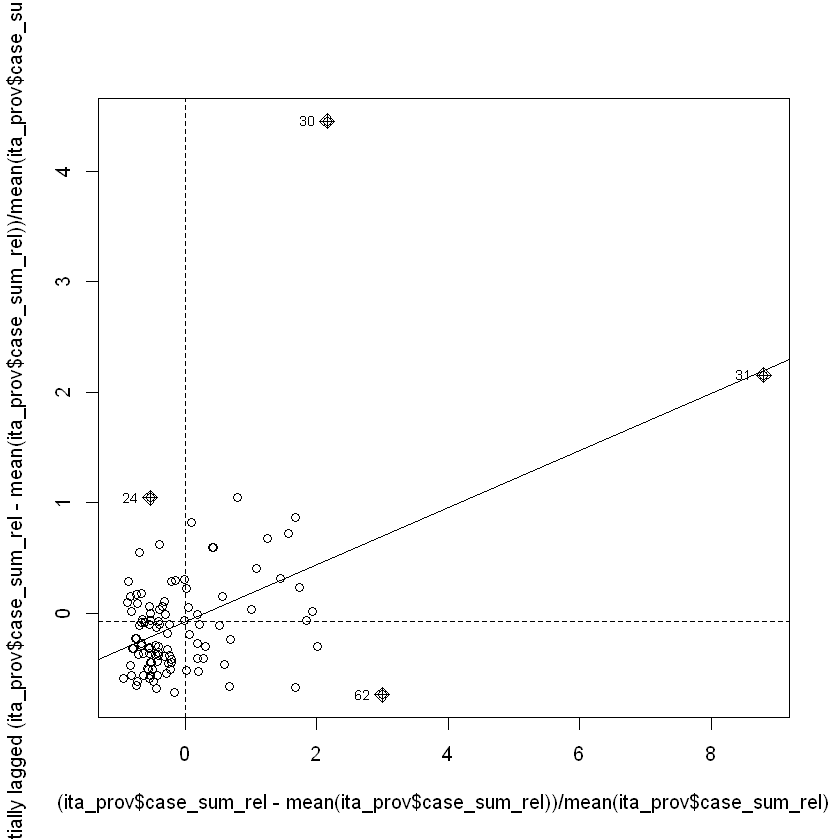

In [13]:
moran.test(ita_prov$case_sum_rel, adj_matrix_norm)
moran.mc(ita_prov$case_sum_rel, adj_matrix_norm, nsim=200)
geary.test(ita_prov$case_sum_rel, adj_matrix_norm)
moran.plot((ita_prov$case_sum_rel-mean(ita_prov$case_sum_rel))/mean(ita_prov$case_sum_rel), adj_matrix_norm)

Since I want to find if there is a spatial correlation between the new cases it is probably more important the distance in terms of k-nn based on centroids (k=4). The number of centroids is not "tuned".<br>
Also in this case, the Moran Index has been calculated using a Monte Carlo procedure in order to test it's significance. <br>
Based on both the Moran randomisation test and on Monte Carlo simulation it is possible to state that there is a very small spatial autocorrelation (it is possible to refuse the null hypothesis of no spatial autocorrelation). <br>


	Moran I test under randomisation

data:  ita_prov$case_sum  
weights: knn_adj_matrix_norm    

Moran I statistic standard deviate = 2.4856, p-value = 0.006467
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.144540698      -0.009433962       0.003837437 



	Monte-Carlo simulation of Moran I

data:  ita_prov$case_sum 
weights: knn_adj_matrix_norm  
number of simulations + 1: 201 

statistic = 0.14454, observed rank = 197, p-value = 0.0199
alternative hypothesis: greater



	Geary C test under randomisation

data:  ita_prov$case_sum 
weights: knn_adj_matrix_norm 

Geary C statistic standard deviate = 1.6768, p-value = 0.0468
alternative hypothesis: Expectation greater than statistic
sample estimates:
Geary C statistic       Expectation          Variance 
       0.87134423        1.00000000        0.00588736 


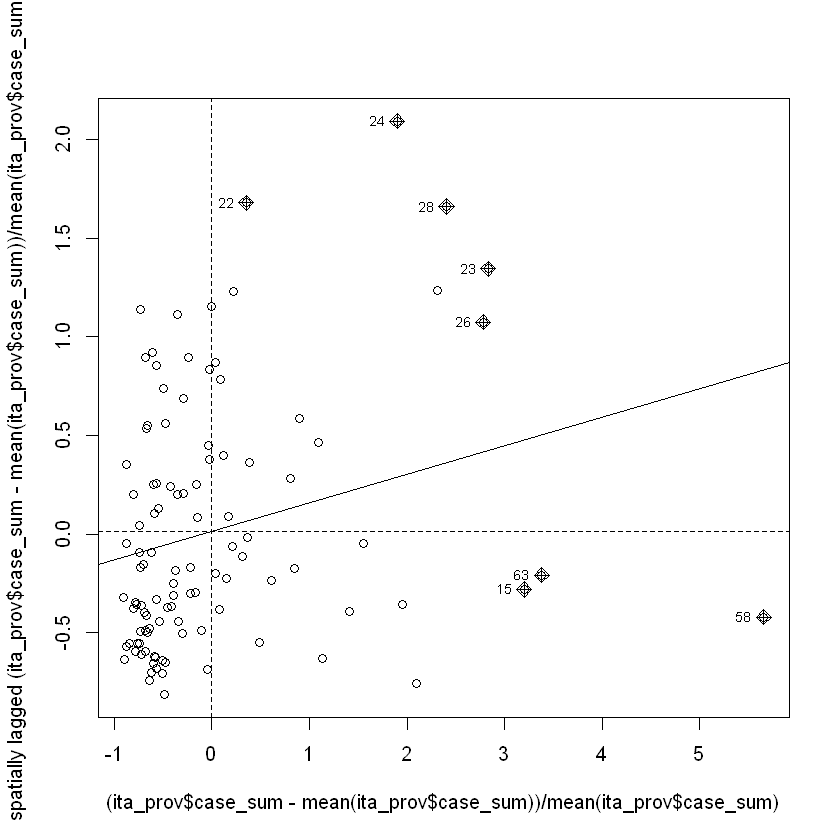

In [14]:
options(jupyter.plot_scale=1.3)
knn_adj = knearneigh(prov_center, k=4)
knn_adj = knn2nb(knn_adj)
knn_adj_matrix_norm <- nb2listw(knn_adj, style = "W")
moran.test(ita_prov$case_sum, knn_adj_matrix_norm)
moran.mc(ita_prov$case_sum, knn_adj_matrix_norm, nsim=200)
geary.test(ita_prov$case_sum, knn_adj_matrix_norm)
moran.plot((ita_prov$case_sum-mean(ita_prov$case_sum))/mean(ita_prov$case_sum), knn_adj_matrix_norm)

Exactly the same plot has been done on the relative increase in number of cases. <br>
Here the Moran Index is still significant but it seems that there is an higher spatial correlation (0.17 vs 0.14).


	Moran I test under randomisation

data:  ita_prov$case_sum_rel  
weights: knn_adj_matrix_norm    

Moran I statistic standard deviate = 3.3724, p-value = 0.0003726
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.174259669      -0.009433962       0.002966979 



	Monte-Carlo simulation of Moran I

data:  ita_prov$case_sum_rel 
weights: knn_adj_matrix_norm  
number of simulations + 1: 201 

statistic = 0.17426, observed rank = 199, p-value = 0.00995
alternative hypothesis: greater



	Geary C test under randomisation

data:  ita_prov$case_sum_rel 
weights: knn_adj_matrix_norm 

Geary C statistic standard deviate = 3.1391, p-value = 0.0008475
alternative hypothesis: Expectation greater than statistic
sample estimates:
Geary C statistic       Expectation          Variance 
       0.68308153        1.00000000        0.01019291 


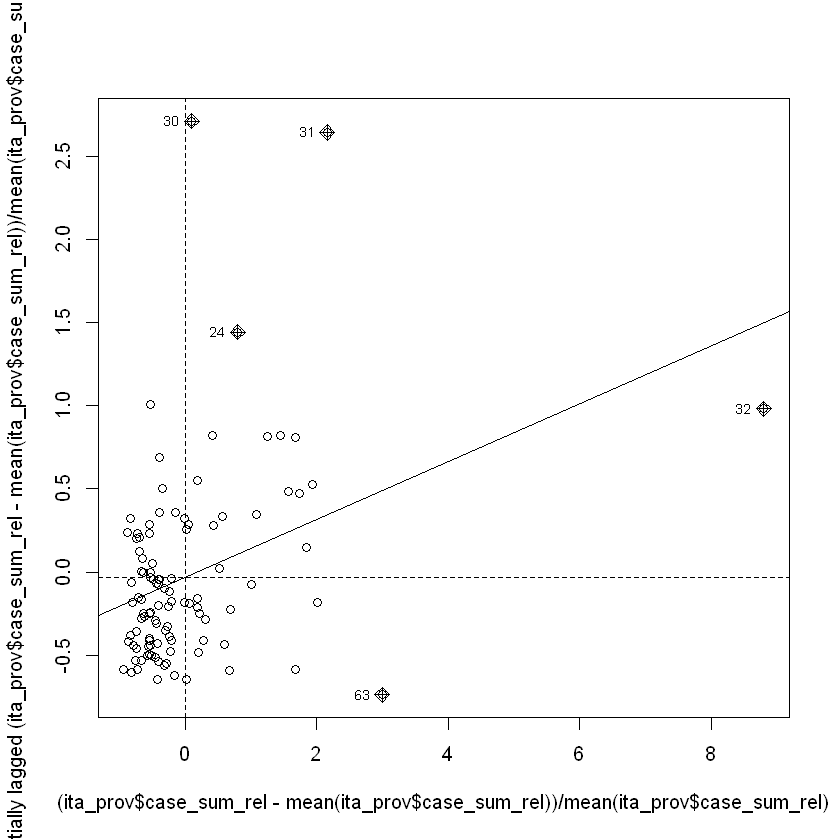

In [15]:
moran.test(ita_prov$case_sum_rel, knn_adj_matrix_norm)
moran.mc(ita_prov$case_sum_rel, knn_adj_matrix_norm, nsim=200)
geary.test(ita_prov$case_sum_rel, knn_adj_matrix_norm)
moran.plot((ita_prov$case_sum_rel-mean(ita_prov$case_sum_rel))/mean(ita_prov$case_sum_rel), knn_adj_matrix_norm)

# 3 - Regression
In this section I tried to find the number of inhabitants divided by age range can be predictors for the number of cases in the period DEC 2020 -> JAN 2021. The expectation is to have a dependence on the age range 20-40 that represents the people who probably came back home for christmas.

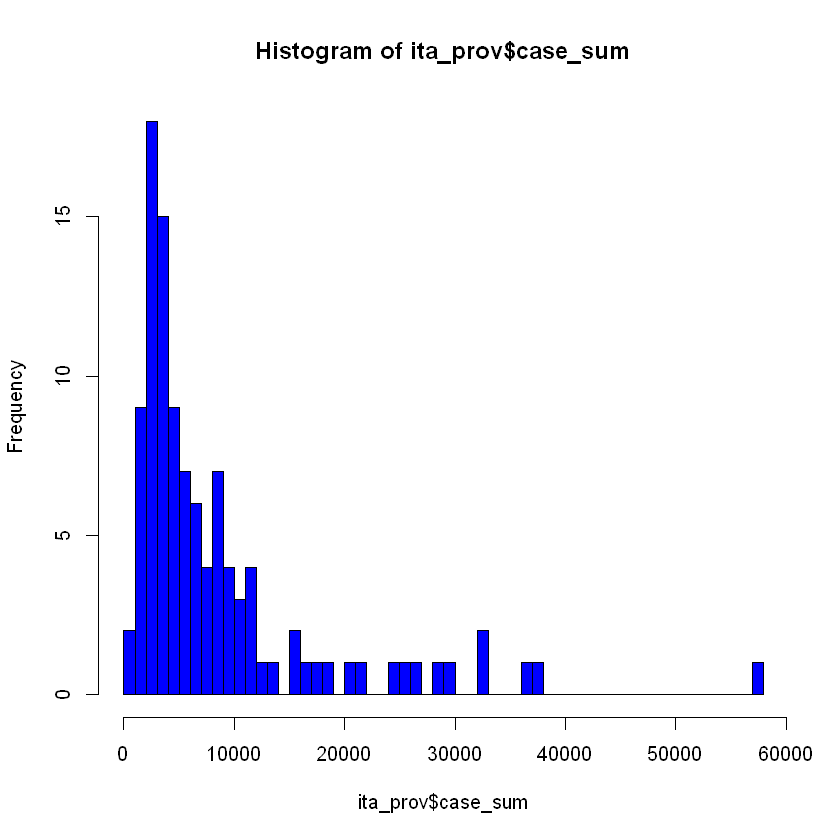

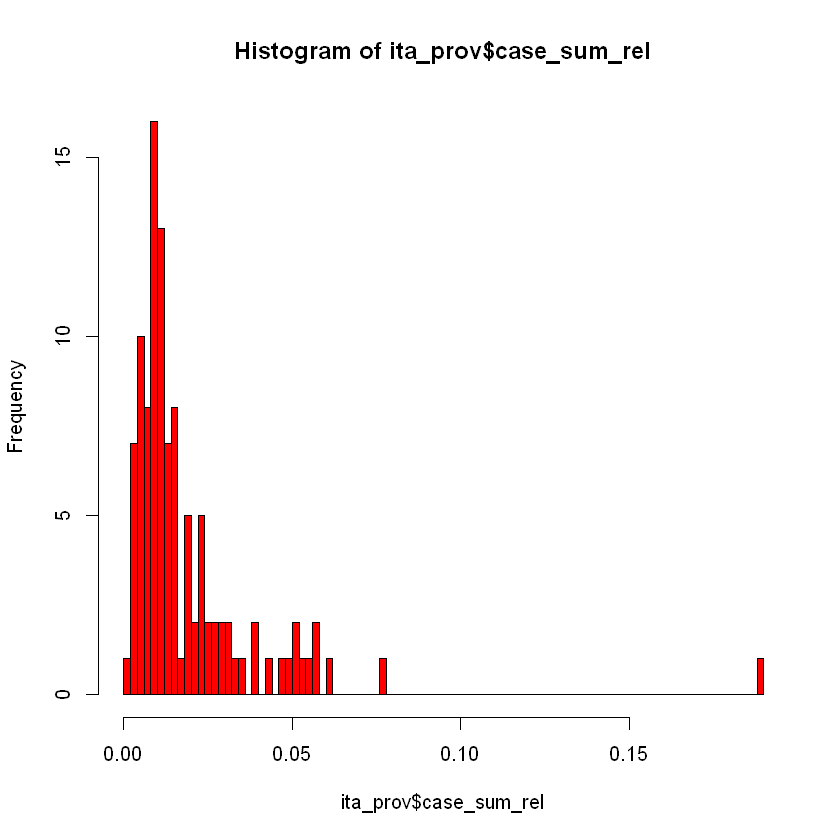

In [16]:
hist(ita_prov$case_sum, col='blue', breaks=50)
hist(ita_prov$case_sum_rel, col='red', breaks=100)

## 3.1 Regression on age range
### 3.1.1 Regress on total cases (case_sum column) - No Spatial Models
In this section I regressed on the total number of new cases in the selected period.

Before fitting any model with spatial dependence I fit a simple linear regression model. <br>
It seems that the only significant variables are the range 0_15, 30_39. All the others have a very high p-value.


Call:
lm(formula = case_sum ~ ., data = data)

Residuals:
   Min     1Q Median     3Q    Max 
-18236  -3762  -1099   2538  31846 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)   
(Intercept)    2879.9377  1671.9316   1.723  0.08820 . 
var_0_15_tot      1.6909     0.6764   2.500  0.01411 * 
var_16_19_tot   -13.5804     7.8955  -1.720  0.08865 . 
var_20_29_tot     5.2984     3.4021   1.557  0.12268   
var_30_39_tot    -3.9399     1.2584  -3.131  0.00231 **
var_40_49_tot     1.6630     0.8889   1.871  0.06440 . 
var_50_59_tot    -0.3680     0.6765  -0.544  0.58775   
var_60_69_tot     0.6214     1.0898   0.570  0.56984   
var_70_79_tot     0.4092     1.0902   0.375  0.70826   
var_80_89_tot    -2.0293     1.1280  -1.799  0.07515 . 
var_90plus_tot    1.9281     2.3418   0.823  0.41235   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 8029 on 96 degrees of freedom
Multiple R-squared:  0.3465,	Adjusted R-squared:  0.2784 
F

,ita_prov.DEN_PCM,data.case_sum,fitted.no_spatial_model.
,<chr>,<int>,<dbl>
1,Torino,26628,16987.280
20,Vercelli,1914,7178.929
31,Novara,4551,5650.319
42,Cuneo,7345,17132.540
53,Asti,3712,5996.284
64,Alessandria,5214,10242.578


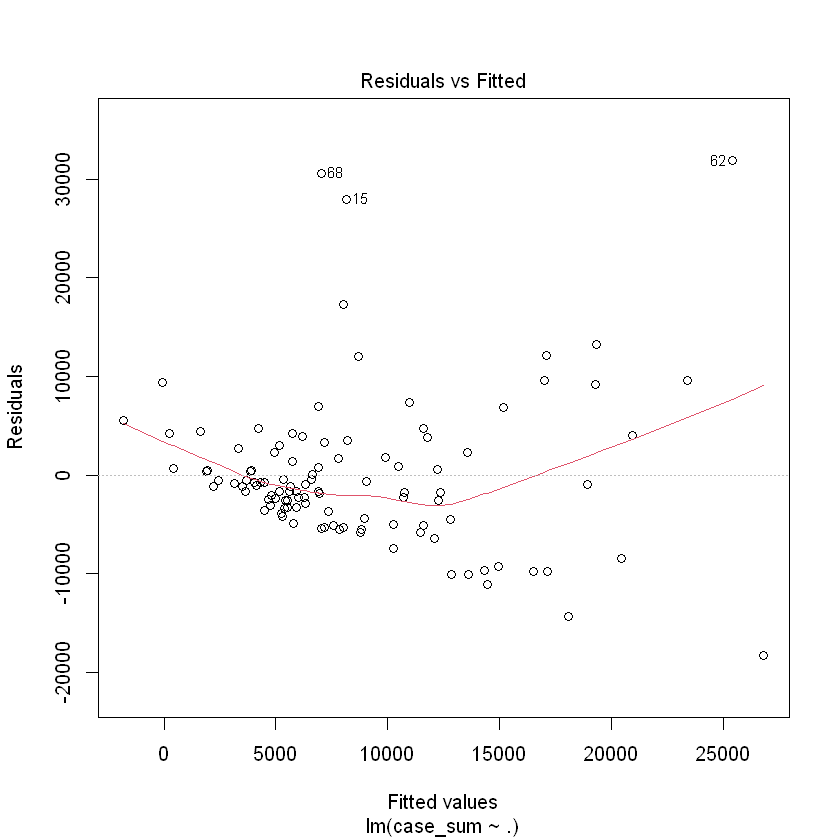

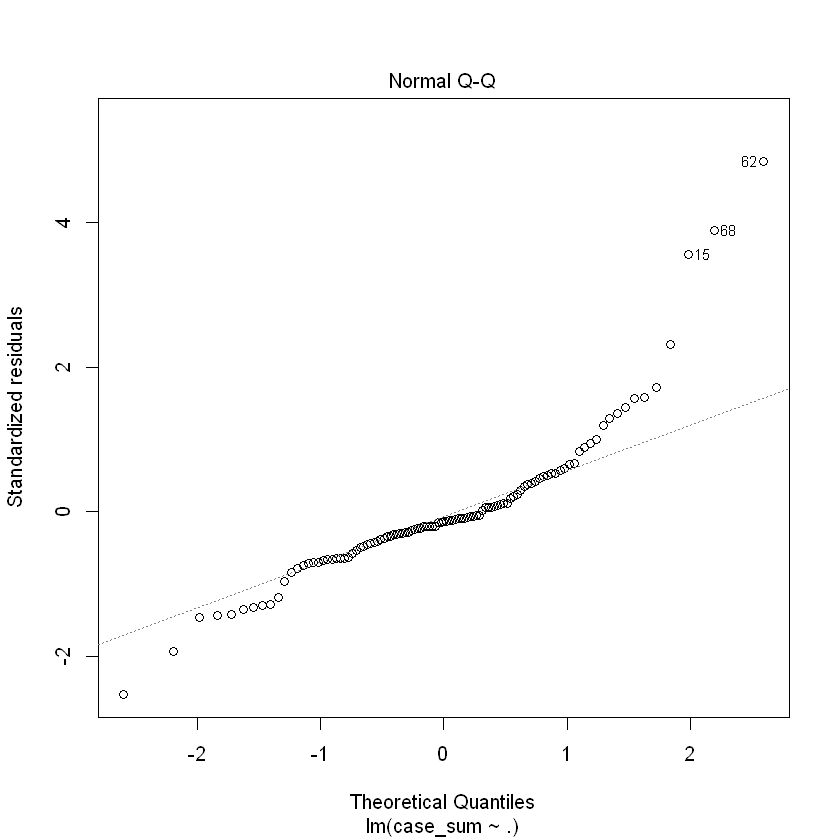

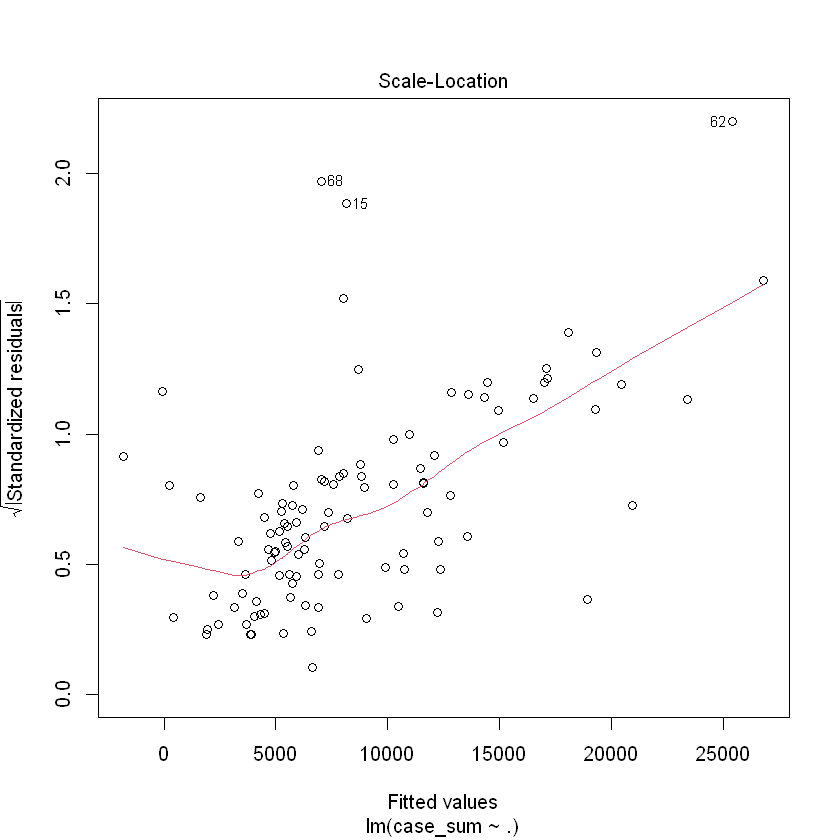

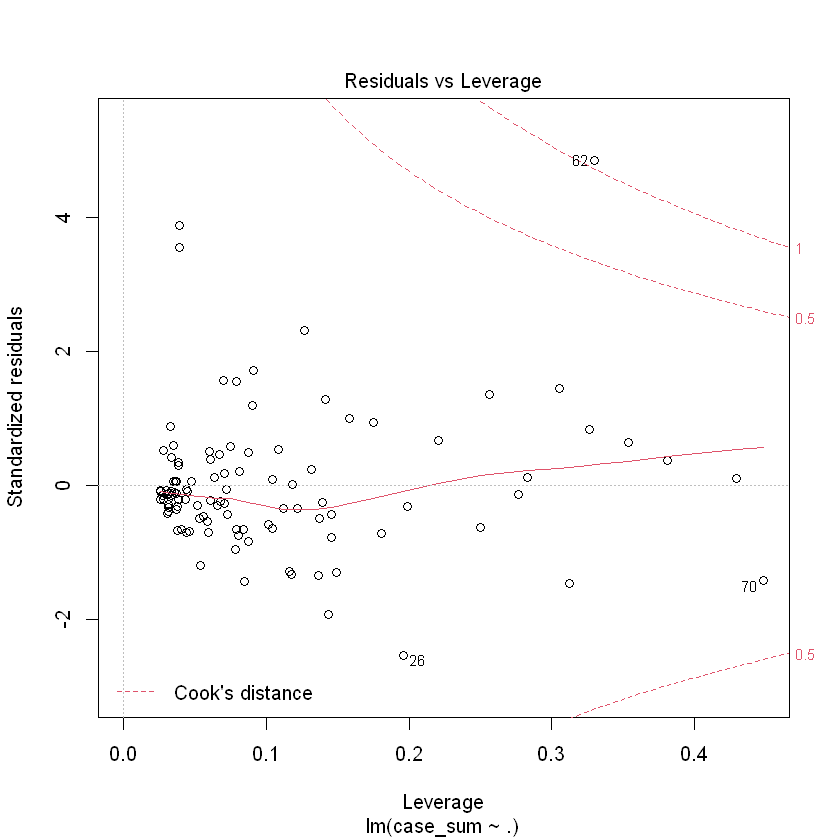

In [17]:
all_columns = c('case_sum') # c('inhabitants','case_sum')
for(r_eta in unique_range_eta){
    all_columns=c(all_columns,paste(r_eta, "_tot", sep=""))
}
data = as.data.frame(ita_prov[all_columns])

no_spatial_model = lm(case_sum ~ ., data = data)
summary(no_spatial_model)
res =  resid(no_spatial_model)
head(data.frame(ita_prov$DEN_PCM,data$case_sum,fitted(no_spatial_model)))
# plot(fitted(no_spatial_model), res)
plot(lm(case_sum ~ ., data = data)) 

Fit a reduced model only on significant variables.


Call:
lm(formula = f, data = data)

Residuals:
   Min     1Q Median     3Q    Max 
-14468  -4283  -2084   1505  41075 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)   
(Intercept)   3910.9354  1399.5047   2.795  0.00619 **
var_0_15_tot     0.6207     0.2683   2.313  0.02269 * 
var_30_39_tot   -0.6768     0.3287  -2.059  0.04198 * 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 8484 on 104 degrees of freedom
Multiple R-squared:  0.2095,	Adjusted R-squared:  0.1943 
F-statistic: 13.78 on 2 and 104 DF,  p-value: 4.904e-06


,ita_prov.DEN_PCM,data.case_sum,fitted.no_spatial_red_model.
,<chr>,<int>,<dbl>
1,Torino,26628,14369.072
20,Vercelli,1914,7099.819
31,Novara,4551,5965.281
42,Cuneo,7345,14476.466
53,Asti,3712,6222.208
64,Alessandria,5214,9364.022


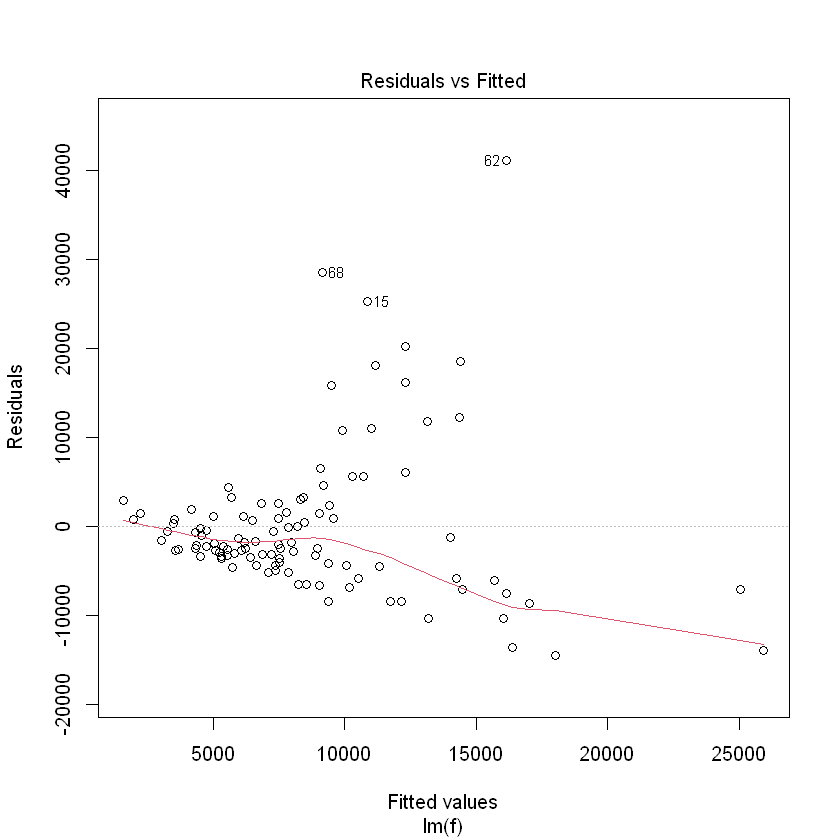

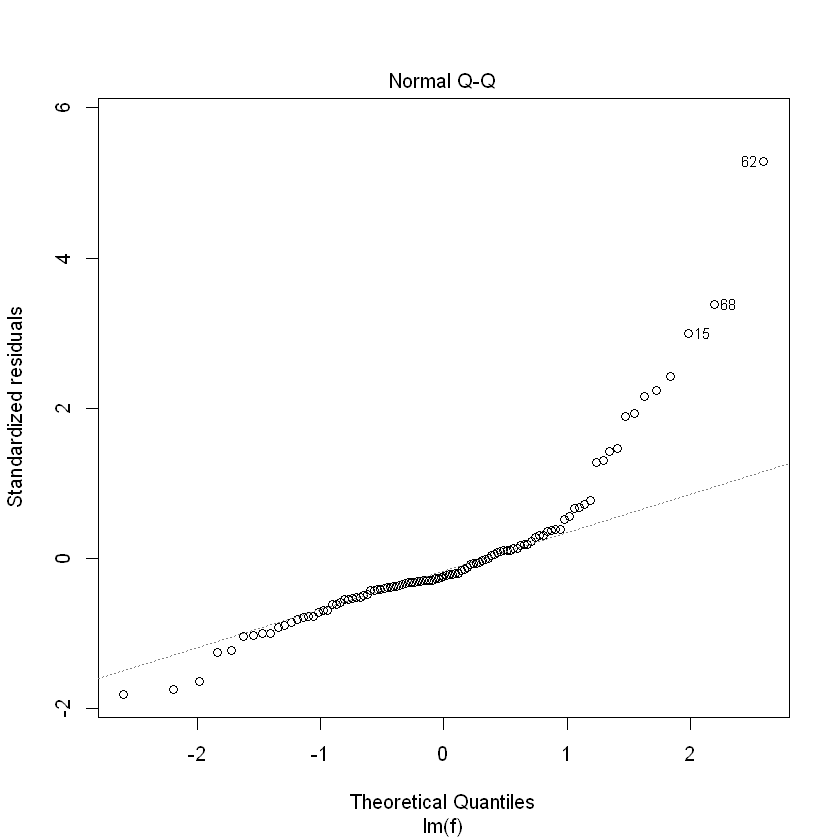

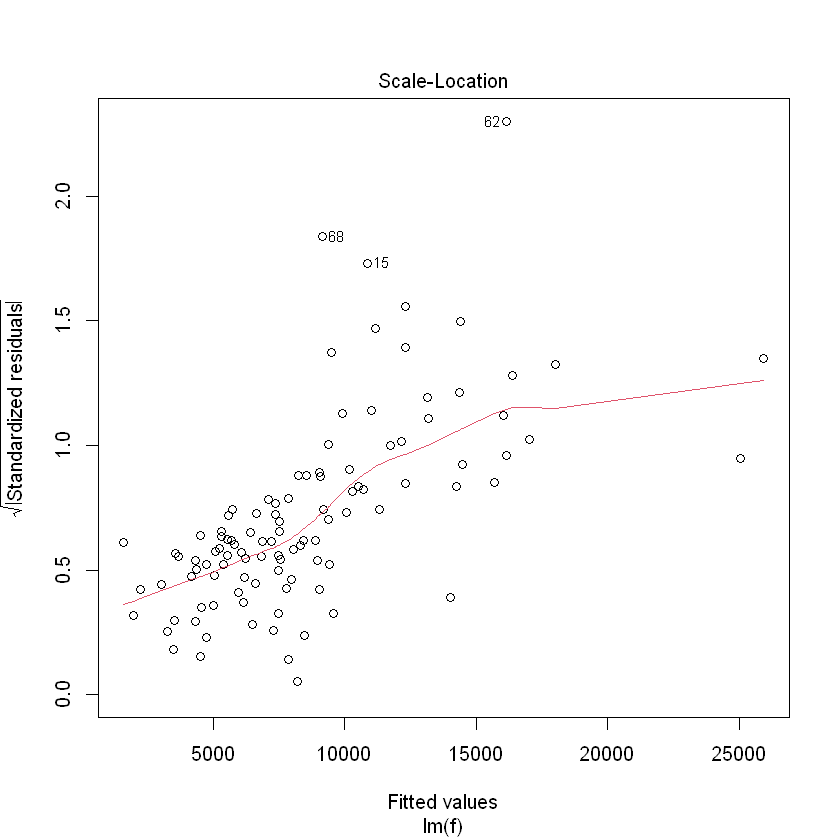

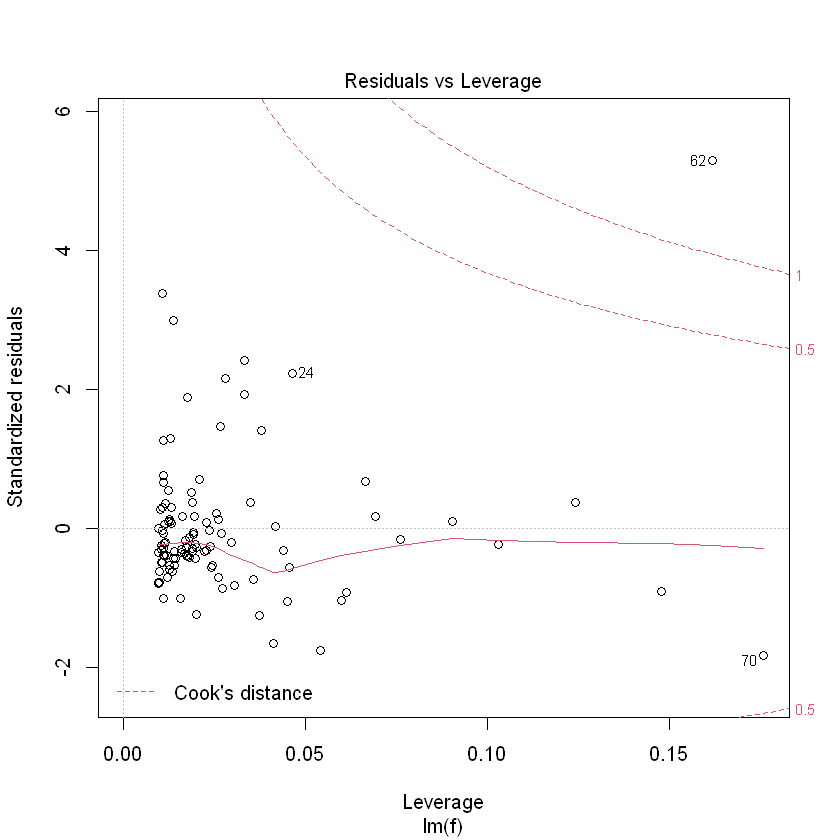

In [18]:
f = case_sum ~ var_0_15_tot + var_30_39_tot
no_spatial_red_model = lm(f, data = data)
summary(no_spatial_red_model)
res =  resid(no_spatial_red_model)
# plot(fitted(no_spatial_model), res)
head(data.frame(ita_prov$DEN_PCM,data$case_sum,fitted(no_spatial_red_model)))
plot(lm(f, data = data))

### 3.1.2 Regress on total cases (case_sum column) - Spatial Models
#### 3.1.2.1 Spatial simultaneous autoregressive error model
Fit a model with spatial error model. <br>

Warning message in errorsarlm(case_sum ~ ., data = data, listw = adj_matrix_norm):
"inversion of asymptotic covariance matrix failed for tol.solve = 2.22044604925031e-16 
  reciprocal condition number = 7.54123e-20 - using numerical Hessian."



Call:errorsarlm(formula = case_sum ~ ., data = data, listw = adj_matrix_norm)

Residuals:
     Min       1Q   Median       3Q      Max 
-17876.4  -4360.0  -1136.3   2956.3  29873.2 

Type: error 
Coefficients: (asymptotic standard errors) 
                 Estimate Std. Error z value  Pr(>|z|)
(Intercept)    3526.66442 1469.18563  2.4004 0.0163762
var_0_15_tot      1.67844    0.51359  3.2681 0.0010828
var_16_19_tot    -9.97032    6.19929 -1.6083 0.1077695
var_20_29_tot     3.87592    2.68390  1.4441 0.1486999
var_30_39_tot    -3.88051    1.00836 -3.8484 0.0001189
var_40_49_tot     1.61713    0.72557  2.2288 0.0258287
var_50_59_tot    -0.38489    0.55389 -0.6949 0.4871301
var_60_69_tot     1.06548    0.87764  1.2140 0.2247374
var_70_79_tot    -0.21723    0.88361 -0.2458 0.8058032
var_80_89_tot    -1.58182    0.89960 -1.7584 0.0786866
var_90plus_tot    1.17506    1.88526  0.6233 0.5330962

Lambda: -0.35043, LR test value: 3.8447, p-value: 0.049902
Approximate (numerical Hessian) standar

This method assumes the response is known - see manual page



,ita_prov.DEN_PCM,data.case_sum,fitted.ser_model.
,<chr>,<int>,<dbl>
1,Torino,26628,17704.700
20,Vercelli,1914,8012.406
31,Novara,4551,4624.061
42,Cuneo,7345,15498.950
53,Asti,3712,6547.066
64,Alessandria,5214,10224.531


This method assumes the response is known - see manual page



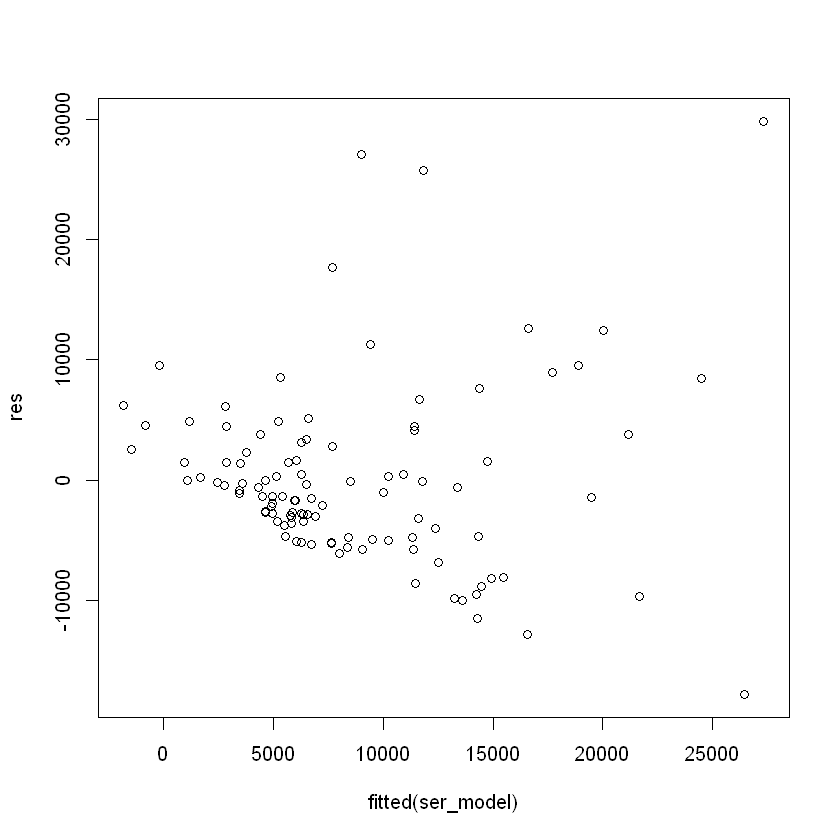

In [19]:
ser_model <- errorsarlm(case_sum ~ ., data = data, listw = adj_matrix_norm)
# Equal to use spautolm(case_sum ~ ., data = data, listw = adj_matrix_norm, family='SAR')
summary(ser_model)
res =  resid(ser_model)
head(data.frame(ita_prov$DEN_PCM,data$case_sum,fitted(ser_model)))
plot(fitted(ser_model), res)
# plot(ser_model)

#### 3.1.2.2 Spatial simultaneous autoregressive lag model
Fit a spatial lag model.
##### Aggiungere commento

Warning message in lagsarlm(case_sum ~ ., data = data, listw = adj_matrix_norm):
"inversion of asymptotic covariance matrix failed for tol.solve = 2.22044604925031e-16 
  reciprocal condition number = 1.1881e-19 - using numerical Hessian."



Call:lagsarlm(formula = case_sum ~ ., data = data, listw = adj_matrix_norm)

Residuals:
     Min       1Q   Median       3Q      Max 
-18651.7  -4267.2  -1254.0   3028.5  30996.3 

Type: lag 
Coefficients: (numerical Hessian approximate standard errors) 
                 Estimate Std. Error z value  Pr(>|z|)
(Intercept)    4001.71840 2045.65800  1.9562 0.0504415
var_0_15_tot      1.81185    0.65448  2.7684 0.0056333
var_16_19_tot   -13.65225    7.27632 -1.8763 0.0606197
var_20_29_tot     5.28779    3.14289  1.6825 0.0924797
var_30_39_tot    -4.13192    1.18532 -3.4859 0.0004905
var_40_49_tot     1.67196    0.82946  2.0157 0.0438301
var_50_59_tot    -0.31041    0.65858 -0.4713 0.6374078
var_60_69_tot     0.69104    1.04721  0.6599 0.5093271
var_70_79_tot     0.37273    1.01684  0.3666 0.7139500
var_80_89_tot    -2.13252    1.06204 -2.0079 0.0446496
var_90plus_tot    1.92714    2.21824  0.8688 0.3849730

Rho: -0.12205, LR test value: 0.74393, p-value: 0.3884
Approximate (numerical Hessi

This method assumes the response is known - see manual page



,ita_prov.DEN_PCM,data.case_sum,fitted.slm_model.
,<chr>,<int>,<dbl>
1,Torino,26628,17577.416
20,Vercelli,1914,7397.528
31,Novara,4551,5222.226
42,Cuneo,7345,17013.014
53,Asti,3712,5776.355
64,Alessandria,5214,10299.303


This method assumes the response is known - see manual page



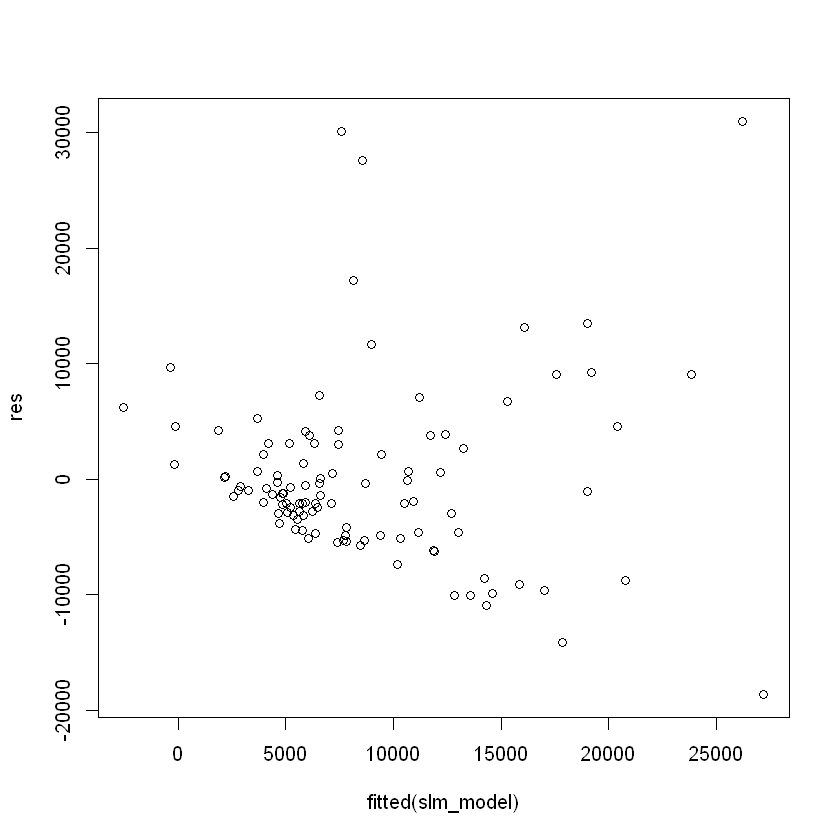

In [20]:
slm_model <- lagsarlm(case_sum ~ ., data = data, listw = adj_matrix_norm)
# Equal to use spautolm(case_sum ~ ., data = data, listw = adj_matrix_norm, family='CAR')
summary(slm_model)
res =  resid(slm_model)
head(data.frame(ita_prov$DEN_PCM,data$case_sum,fitted(slm_model)))
plot(fitted(slm_model), res)
# plot(ser_model) 

#### 3.1.2.3 Spatial Durbin model
Fit a Durbin model.
##### Aggiungere commento

Warning message in lagsarlm(case_sum ~ ., data = data, listw = adj_matrix_norm, :
"inversion of asymptotic covariance matrix failed for tol.solve = 2.22044604925031e-16 
  reciprocal condition number = 8.3495e-20 - using numerical Hessian."



Call:lagsarlm(formula = case_sum ~ ., data = data, listw = adj_matrix_norm, 
    type = "mixed")

Residuals:
      Min        1Q    Median        3Q       Max 
-14266.56  -3832.73   -404.75   3039.15  31763.04 

Type: mixed 
Coefficients: (numerical Hessian approximate standard errors) 
                      Estimate  Std. Error z value Pr(>|z|)
(Intercept)         1.0661e+04  3.4712e+03  3.0713 0.002131
var_0_15_tot        1.4371e+00  7.4850e-01  1.9199 0.054869
var_16_19_tot      -1.6551e+01  6.4182e+00 -2.5787 0.009917
var_20_29_tot       6.4881e+00  2.4622e+00  2.6351 0.008411
var_30_39_tot      -3.7854e+00  1.1808e+00 -3.2058 0.001347
var_40_49_tot       2.0276e+00  7.7721e-01  2.6088 0.009085
var_50_59_tot      -4.9305e-01  6.3928e-01 -0.7713 0.440553
var_60_69_tot       3.2805e-02  2.9680e-01  0.1105 0.911990
var_70_79_tot       6.3860e-01  8.6322e-01  0.7398 0.459427
var_80_89_tot      -1.2997e+00  1.1628e+00 -1.1177 0.263689
var_90plus_tot      3.3857e-01  2.0323e+00  0.1666 

This method assumes the response is known - see manual page



,ita_prov.DEN_PCM,data.case_sum,fitted.durbin_model.
,<chr>,<int>,<dbl>
1,Torino,26628,20441.1685
20,Vercelli,1914,8899.8149
31,Novara,4551,5691.2692
42,Cuneo,7345,13684.0234
53,Asti,3712,102.3683
64,Alessandria,5214,7599.7609


This method assumes the response is known - see manual page



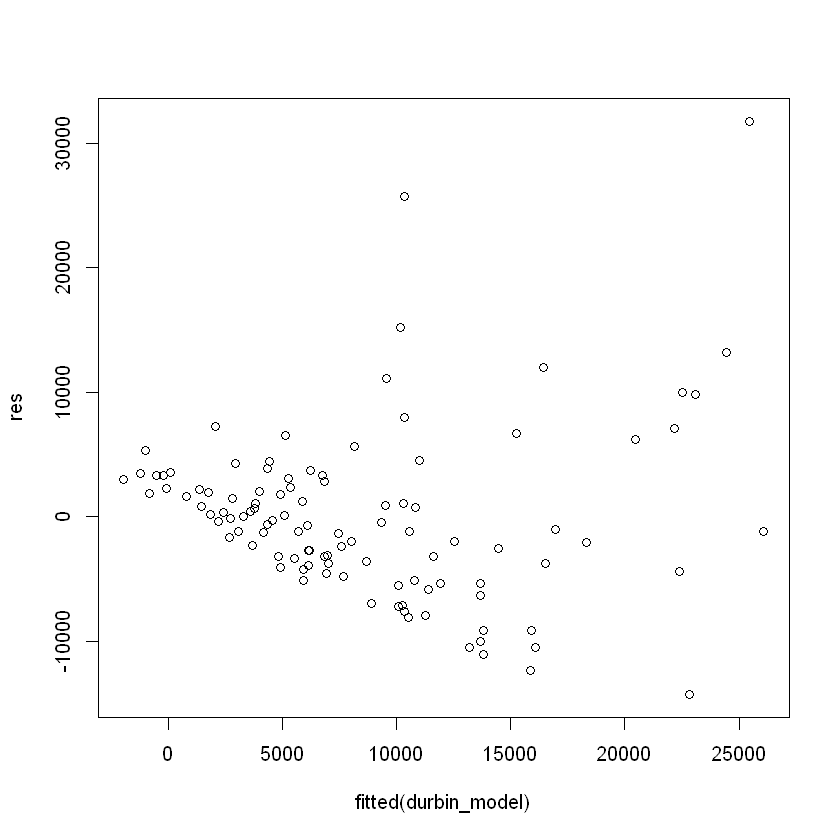

In [21]:
durbin_model <- lagsarlm(case_sum ~ ., data = data, listw = adj_matrix_norm, type='mixed')
summary(durbin_model)
res =  resid(durbin_model)
head(data.frame(ita_prov$DEN_PCM,data$case_sum,fitted(durbin_model)))
plot(fitted(durbin_model), res)
# plot(ser_model) 

# Backup

In [ ]:
# aggregate(dati_covid_jan21$totale_casi, by=list(Category=x$Category), FUN=sum)
# a = subset(dati_covid_jan21, codice_provincia==1)
# diff(a$totale_casi)
# dati_covid_jan21$myVar = aggregate(dati_prov_covid$totale_casi, by=list(dati_covid_jan21$"COD_PROV"), FUN=mean)$x
# subset(dati_prov_covid_jan21, COD_PROV==880)

In [ ]:
data

In [ ]:
write.csv(as.data.frame(as.data.frame(ita_prov[c('DEN_PROV',all_eta,'inhabitants')])),"cdd2.csv", row.names = TRUE)

In [ ]:
df = data.frame(data$case_sum,data[c('30-39_tot')])
colnames(df) = c('y','x')
model = lm(y ~ x, data = df)
summary(model)
plot(model)

In [ ]:
df

In [ ]:
str_replace('aa_bb_cc-d','-','test')

In [ ]:
dati_stat = read.csv("C:/Users/peppu/Documents/MyPythonProject/COVID-19/dati-statistici-riferimento/popolazione-istat-regione-range.csv")
dati_stat$COD_REG = as.numeric(dati_stat$codice_regione)
dati_stat[dati_stat=='0-15'] = '0_15'
head(dati_stat)

In [ ]:
dati_stat = read.csv("C:/Users/peppu/Documents/MyPythonProject/COVID-19/dati-statistici-riferimento/popolazione-istat-regione-range.csv")
dati_stat$COD_REG = as.numeric(dati_stat$codice_regione)
unique_range_eta = unique(dati_stat$range_eta)
for(r_eta in unique_range_eta){
    new_str = str_replace(r_eta,'-','_')
    new_str = str_replace(new_str,'\\+','plus')
    dati_stat[dati_stat==r_eta] = new_str
    }
head(dati_stat)

In [ ]:
t_for_plot = table(data)

# print('Frequenze assolute = ')
# t_for_plot
# print('Frequenze relative = ')
prop.table(t_for_plot, margin=2)
bar = barplot(data, beside=F, legend=c('not sick','sick'),col = c("blue", "red"),
              xlab='Age classes', ylab = 'Absolute frequencies',axis.lty = 1)
# bar = barplot(prop.table(t_for_plot, margin=2), beside=F, col = c("blue", "red"),
#               xlab='Age classes', ylab = 'Relative frequencies',axis.lty = 1)

In [ ]:
bar = barplot(data$case_sum)

In [ ]:
anova(no_spatial_model, no_spatial_red_model)

In [ ]:
sum(residuals(durbin_model)^2)

In [ ]:
colnames(as.data.frame(ita_prov))

In [ ]:
summary(slm_model)

In [ ]:
summary(spautolm(case_sum ~ ., data = data, listw = adj_matrix_norm, family='CAR'))

In [ ]:
adj_matrix_norm